In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install pytorch-lightning torchbench

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 16.9 MB/s eta 0:00:00
  Created wheel for tabulate: filename=tabulate-0.8.3-py3-none-any.whl size=23375 sha256=15ee01a6b6f20da616d9172087caabcd303b701b4cd2eb830343e0a998d3e227
  Stored in directory: /root/.cache/pip/wheels/ea/f4/08/6ac7d5e3a397d0e56

In [3]:
!pip install pytorch-lightning pycocotools

In [4]:
!pip install safetensors

In [5]:
!unzip ComputerVision_Semantic_Segmentation.zip

Archive:  ComputerVision_Semantic_Segmentation.zip
   creating: ComputerVision_Semantic_Segmentation/
  inflating: ComputerVision_Semantic_Segmentation/lora_ade.ipynb  
  inflating: ComputerVision_Semantic_Segmentation/main.py  
  inflating: ComputerVision_Semantic_Segmentation/model_2.py  
  inflating: ComputerVision_Semantic_Segmentation/sam_lora.py  
  inflating: ComputerVision_Semantic_Segmentation/train.py  
  inflating: ComputerVision_Semantic_Segmentation/train_2.py  
  inflating: ComputerVision_Semantic_Segmentation/utils.py  
  inflating: ComputerVision_Semantic_Segmentation/utils_2.py  
  inflating: ComputerVision_Semantic_Segmentation/viz.py  
  inflating: ComputerVision_Semantic_Segmentation/.gitignore  
   creating: ComputerVision_Semantic_Segmentation/.git/
  inflating: ComputerVision_Semantic_Segmentation/.git/index  
  inflating: ComputerVision_Semantic_Segmentation/.git/description  
  inflating: ComputerVision_Semantic_Segmentation/.git/config  
  inflating: ComputerV

In [1]:
%cd ComputerVision_Semantic_Segmentation

/content/ComputerVision_Semantic_Segmentation


In [4]:
!pip install -e ./segment-anything-main/

Obtaining file:///content/ComputerVision_Semantic_Segmentation/segment-anything-main
  Preparing metadata (setup.py) ... done
  Attempting uninstall: segment-anything
    Found existing installation: segment-anything 1.0
    Uninstalling segment-anything-1.0:
      Successfully uninstalled segment-anything-1.0
  Running setup.py develop for segment-anything


In [2]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

--2023-12-16 03:26:02--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.224.250.114, 13.224.250.108, 13.224.250.75, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.224.250.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth.5’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   230MB/s    in 1.6s    

2023-12-16 03:26:03 (230 MB/s) - ‘sam_vit_b_01ec64.pth.5’ saved [375042383/375042383]



In [3]:
from utils import *
from sam_lora import *



sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
lora_sam = LoRA_Sam(sam,r = 4)

In [4]:
import torch
from torch import nn
import numpy as np
import pytorch_lightning as pl
from torchbench.datasets import ADE20K
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_tensor, pil_to_tensor, resize, normalize
from torchvision.transforms import InterpolationMode
from torch.utils.data import Subset, DataLoader
from tqdm import tqdm

In [5]:
def simple_ade20k_transforms(image, target):
    image = resize(to_tensor(image), (256, 256))
    image = normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    target = resize(pil_to_tensor(target), (64, 64), InterpolationMode.NEAREST)[0].long()
    # 0: background, -1: plant, -2: person/animal, -3: vehicle
    class_mapping = [(5, -1), (10, -1), (13, -2), (18, -1), (21, -3), (67, -1),
                     (77, -3), (84, -3), (91, -3), (103, -3), (104, -3), (127, -2), (128, -3)]
    for cm in class_mapping:
        target[target == cm[0]] = cm[1]
    target[target > 0] = 0
    target *= -1
    return image, target

In [6]:
train_dataset = ADE20K('data', 'train', download=True, transforms=simple_ade20k_transforms)
val_dataset = ADE20K('data', 'val', transforms=simple_ade20k_transforms)

You set download=True, but a folder VOCdevkit already exist in the root directory. If you want to re-download or re-extract the archive, delete the folder.


In [7]:
train_loader = DataLoader(train_dataset, batch_size=16)
val_loader = DataLoader(val_dataset, batch_size=16)

In [8]:
def trim_dataset(dataset):
    valid_indices = []
    for entry in tqdm(range(len(dataset))):
        _, target = dataset[entry]
        if (target > 0).float().mean() > 0.01:
            valid_indices.append(entry)
    if len(dataset) > len(valid_indices):
        dataset = Subset(dataset, valid_indices)
    return dataset

train_dataset = trim_dataset(train_dataset)
val_dataset = trim_dataset(val_dataset)

  0%|          | 0/20210 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 2000/2000 [00:09<00:00, 212.22it/s]


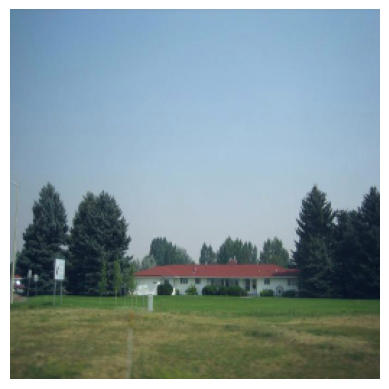

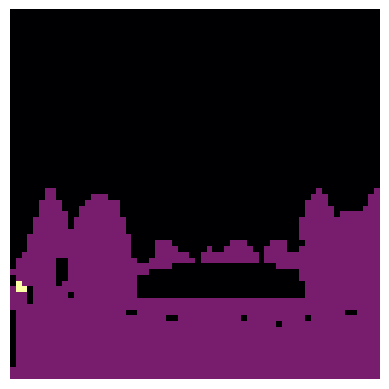

In [9]:
idx = 500
plt.imshow(train_dataset[idx][0].permute(1, 2, 0) / 4 + 0.5) # just for visualization
plt.axis('off')
plt.show()
plt.imshow(train_dataset[idx][1], vmin=0, vmax=3, cmap='inferno')
plt.axis('off')
plt.show()

In [10]:
train_dataset[idx][0].shape

torch.Size([3, 256, 256])

In [11]:
from torch.utils.data import Subset
indices = range(50)
subset_dataset = Subset(train_dataset, indices)

In [12]:
num_epochs = 10
device = 'cuda'
optimizer = torch.optim.Adam(lora_sam.sam.parameters(), lr=1e-5)
lora_sam.sam.to(device)
criteria = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
  running_loss = 0.0
  running_cate_loss = 0.0
  running_mask_loss = 0.0
  running_iou_loss = 0.0

  pbar = tqdm(subset_dataset, desc=f"Epoch [{epoch + 1}/{num_epochs}]")

  count = 0

  for image, targets in pbar:
    count += 1
    optimizer.zero_grad()

    # image = F.interpolate(image[None, :], size=(1024, 1024), mode='bilinear')
    image = image.unsqueeze(0)
    image = image.to(device)

    target = targets[None, :]  # TODO: batch
    target_tensor = target.clone()
    batch_size, height, width = target_tensor.shape
    selected_target = target_tensor

    selected_target = selected_target.to(device)

    features = lora_sam.sam.image_encoder(image)

    sparse_embeddings, dense_embeddings = lora_sam.sam.prompt_encoder(
                points=None,
                boxes=None,
                masks=None,
                )

    image_pe_scaled = lora_sam.sam.prompt_encoder.get_dense_pe()

    low_res_masks, iou_predictions = lora_sam.sam.mask_decoder(
                image_embeddings=features,
                image_pe=image_pe_scaled,
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                # multimask_output=False,
                multimask_output=True
            )

    selected_target = selected_target.float()
    # selected_target = F.interpolate(selected_target.unsqueeze(0), scale_factor=4, mode='nearest')
    selected_target = selected_target.long()
    selected_target = selected_target.to(device)

    low_res_masks = low_res_masks.permute(0, 2, 3, 1).reshape(-1, 4)
    selected_target = selected_target.reshape(-1)
    loss = criteria(low_res_masks, selected_target)
    # loss = mask_dice_loss(low_res_masks, selected_target)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    pbar.set_postfix({
              'Total Loss': f"{running_loss / (pbar.n + 1):.4e}"
          })



Epoch [10/10]: 100%|██████████| 50/50 [00:03<00:00, 13.19it/s, Total Loss=3.1996e-01]


In [13]:
idx_ = 6

image = subset_dataset[idx_][0]
targets = subset_dataset[idx_][1]

In [14]:
# np.save('img_2.npy', image0)

# image0 = np.load('orig_img.npy')
# image0 = torch.tensor(image0)

In [15]:
select_channel = 0

In [16]:
lora_sam.sam.to(device)


# image = F.interpolate(image0[None, :], size=(1024, 1024), mode='bilinear')
image = image.unsqueeze(0)
image = image.to(device)

target = targets[None, :]  # TODO: batch
target_tensor = target.clone()
batch_size, height, width = target_tensor.shape
one_hot_target = torch.zeros(batch_size, 4, height, width).to(target_tensor.device)
one_hot_target.scatter_(1, target_tensor.unsqueeze(1), 1)
selected_target = one_hot_target
# selected_target = selected_target[0, select_channel]
selected_target = selected_target[0]

selected_target = selected_target.to(device)

features = lora_sam.sam.image_encoder(image)

sparse_embeddings, dense_embeddings = lora_sam.sam.prompt_encoder(
            points=None,
            boxes=None,
            masks=None,
            )

image_pe_scaled = lora_sam.sam.prompt_encoder.get_dense_pe()

low_res_masks, iou_predictions = lora_sam.sam.mask_decoder(
            image_embeddings=features,
            image_pe=image_pe_scaled,
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=True,
        )

In [17]:
low_res_masks.shape

torch.Size([1, 4, 64, 64])

In [19]:
low_res_masks.shape
# mask_plot = low_res_masks[0, select_channel].cpu().detach().numpy()
mask_plot = low_res_masks[0].cpu().detach().numpy()
mask_gt_plot = selected_target.cpu().detach().numpy()
image_plot = image[0].permute(1, 2, 0).cpu().detach().numpy()

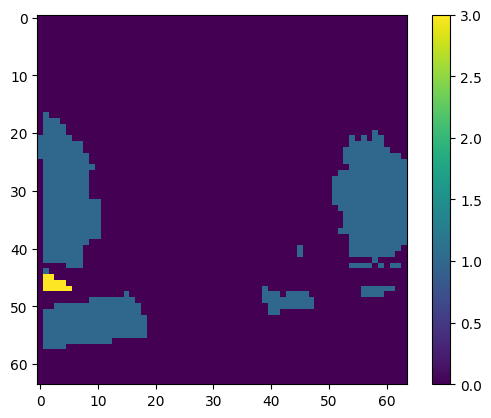

In [20]:
mask_gt_plot = np.argmax(mask_gt_plot, axis=0)

img = plt.imshow(mask_gt_plot)
plt.colorbar(img)
plt.show()

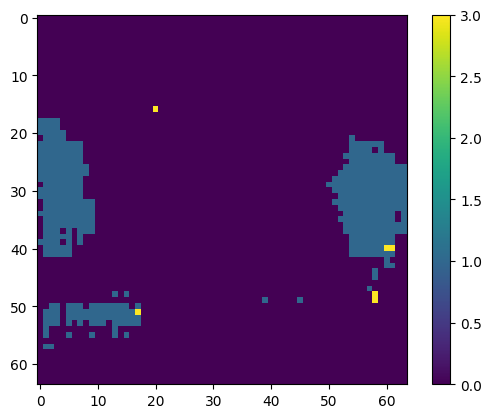

In [21]:
mask_plot = np.argmax(mask_plot, axis=0)

img = plt.imshow(mask_plot)
plt.colorbar(img)
plt.show()

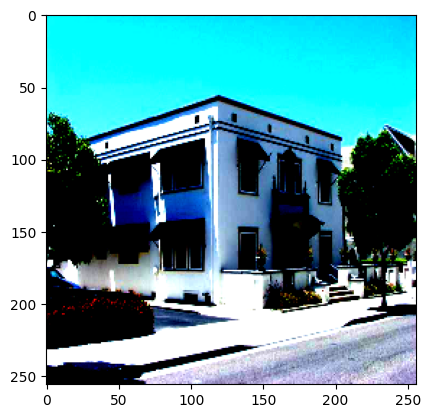

In [22]:
plt.imshow(image_plot)
plt.show()